# Individual Project

Using Twitter API to collect the tweets about 3 stocks in 2 weeks of December. Do some basic text analysis e.g. most common words per stock, word cloud per stock, simple sentiment detection (positive/negative), etc.

Important Python libraries:
- tweepy
- pandas
- nltk

Note:
- Twitter may limit the amount and duration of tweet to collect. Make sure to start collect as soon as possible.
- The student should spend some time to learn the basic text processing methods.
---------------------------------------------------------------------------------------------------------------------------
Target business sector: Financial in US

---------------------------------------------------------------------------------------------------------------------------
Tweepy
https://www.tweepy.org/

NASDAQ Stock - Symbol Screener
https://www.nasdaq.com/market-activity/stocks/screener

Turn Your Twitter Timeline into a Word Cloud
https://sebastianraschka.com/Articles/2014_twitter_wordcloud.html 

Text Analytics for Beginners using NLTK
https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk

Sentiment Analysis
http://www.nltk.org/howto/sentiment.html

Comprehensive Hands on Guide to Twitter Sentiment Analysis with dataset and code
https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

Topic Modeling of Twitter Timelines in Python
https://medium.com/@alexisperrier/topic-modeling-of-twitter-timelines-in-python-bb91fa90d98d 

Stocks choosen based on Fortune 500 list 2019 (https://fortune.com/fortune500/2019/search/?sector=Financials)

Berkshire Hathaway (Warren Buffet)

JP Morgan (Chase)

Capital One

# Import packages

In [61]:
import tweepy
import pandas as pd
import numpy as np
import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import re
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
from gensim import corpora
import pyLDAvis.gensim
import pyLDAvis
import gensim

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pborchert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pborchert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pborchert\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# API Setup and Variable Definition

In [62]:
# API Keys for Tweepy

consumer_key        = #Removed
consumer_secret     = #Removed
access_token        = #Removed
access_token_secret = #Removed

In [63]:
# Acces Tweepy API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [64]:
#Define Search Terms and start_date
start_date       = "2019-12-01" #YYYY-MM-DD
berkshire_query  = "Berkshire Hathaway" #Warren Buffet
jpmorgan_query   = "JP Morgan"
capitalone_query = "Capital One"

company_list=["BRK.A", 'JPM', 'COF']

# Initialize Functions used in Main and Analysis

In [65]:
# Function returns dataframe with tweets (+ attributes) regarding input search term (Query strings defined above)

def getweets(search_term, last_tweet_id = 0):
    
    #x = tweets_df.tweet_id.max()

    
    # API search for specified search_term
    # if last_tweet_id is specified, a delta search is performed
    
    if last_tweet_id == 0:
        # last_tweet_id not specified (full search)
        res = tweepy.Cursor(api.search,q=search_term, #since_id = insert latest id called
                                since= start_date,    #only tweets from the 2019/12/01 (YYYY/MM/DD) will be considered
                                lang="en",
                                result_type="recent"
                                ).items()
        
    #(https://stackoverflow.com/questions/29754885/is-there-a-way-to-tell-if-one-tweet-was-created-after-another-based-on-the-tweet/29759840)
    else:
        # last_tweet_id specified (delta search)
        res = tweepy.Cursor(api.search,q=search_term,
                                since_id = last_tweet_id,
                                #max_id = last_tweet_id,
                                since= start_date,    #only tweets from the 2019/12/01 (YYYY/MM/DD) will be considered
                                lang="en",
                                result_type="recent"
                                ).items()
        
    tweet_list = []
    for tweet in res:
        #Filter Retweets 
        if tweet.retweeted == True:
            continue
        elif tweet.text[:2] == "RT":
            continue

        #save attributes per tweet in tweet_list
        tweet_id        = tweet.id 
        text            = tweet.text 
        follower_count  = tweet.user.followers_count
        retweet_count   = tweet.retweet_count
        created_at      = tweet.created_at 
        source          = tweet.source 
        reply_to_status = tweet.in_reply_to_status_id # if reply int of orginal tweet id
        user_name       = tweet.user.screen_name

        tweet_list.append({"tweet_id"       : tweet_id, 
                          "text"            : text,
                          "follower_count"  : follower_count,
                          "retweet_count"   : retweet_count,
                          "created_at"      : created_at, 
                          "source"          : source, 
                          "reply_to_status" : reply_to_status, 
                          "user_name"       : user_name                       
                          })
        
    # create dataframe from tweet_list
    tweets_df = pd.DataFrame(tweet_list, columns = ["tweet_id",
                                           "text",
                                           "follower_count",
                                           "retweet_count",
                                           "created_at",
                                           "source",
                                           "reply_to_status",
                                           "user_name",
                                            ])
    
    # Splits created_at (date) column in time and date (used in visualization) 
    tweets_df['new_date'] = [d.date() for d in tweets_df['created_at']]
    tweets_df['new_time'] = [d.time() for d in tweets_df['created_at']]
    
    # Remove duplicate tweets from the same user_name. So duplicate tweets from one user don't have more weight in the sentiment analysis
    # First tweet will be kept
    print(search_term, tweets_df.shape)
    tweets_df = tweets_df.drop_duplicates(subset=["text","user_name"], keep="first")
    tweets_df.reset_index(drop=True, inplace=True)
    print(tweets_df.shape, "\n")
    
    return tweets_df

In [66]:
def remove_pattern(input_txt, pattern):
    
    # removes pattern from specified text string
    # https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
    
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [67]:
# extend nltk stop_word list with strings found in tweets
stop_words = stopwords.words("english")
stop_words.append("#")
stop_words.append("https")
stop_words.append(":")
stop_words.append(".")
stop_words.append("$")
stop_words.append("?")
stop_words.append("'")
stop_words.append("amp")

In [68]:
def clean(df):
    
    # Cleans the "text" column of a specified dataframe and creates "tidy_text" and "text_tokens" columns
    
    tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=True)
    ps = PorterStemmer()
    
    # Remove urls
    df['tidy_text'] = df['text'].str.replace("[a-z]*[:.]+\S+", "")
    #result = re.sub(r"http\S+", "", subject)
    # Remove Usernames
    df['tidy_text'] = np.vectorize(remove_pattern)(df['tidy_text'], "@[\w]*")
    # Remove non-letters
    df['tidy_text'] = df['tidy_text'].str.replace("[^a-zA-Z#]", " ")
    # remove tokens < 3 letters
    df['tidy_text'] = df['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
    
    # Tokenize Text
    df['text_tokens'] = df['tidy_text'].apply(lambda x: tknzr.tokenize(x))
    #df['text_tokens'] = df['text_tokens'].apply(lambda x: [ps.stem(w) for w in x])
    
    # Remove stop_words
    df['text_tokens'] = df['text_tokens'].apply(lambda x: [w for w in x if not w in stop_words])

<>:9: DeprecationWarning: invalid escape sequence \S
<>:12: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \S
<>:12: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \S
<>:12: DeprecationWarning: invalid escape sequence \w
<ipython-input-68-2cb3e7a13a2d>:9: DeprecationWarning: invalid escape sequence \S
  df['tidy_text'] = df['text'].str.replace("[a-z]*[:.]+\S+", "")
<ipython-input-68-2cb3e7a13a2d>:12: DeprecationWarning: invalid escape sequence \w
  df['tidy_text'] = np.vectorize(remove_pattern)(df['tidy_text'], "@[\w]*")


In [69]:
def updatedf(df1, df2):
    
    # Appends two specified dataframes
    # Used to merge all delta- and full searches into one dataframe
    # Removes duplicate tweets from the same user
    # Returns merged dataframe
    
    print(df1.shape)
    df3 = df1.append(df2, ignore_index=True, sort=False)
    print(df3.shape)
    df3 = df3.drop_duplicates(subset=["text","user_name"], keep="first")
    df3.reset_index(drop=True, inplace=True)
    print(df3.shape, "\n")
    
    return df3

In [109]:
def drawordcloud(df):
    
    # prints wordcloud based on "text_tokens" column for specified dataframe
    # masks may require different settings in WordCloud call (e.g. width, height)
    
    clean_string = ' '.join(df["text_tokens"].apply(lambda x: " ".join(x[1:-1])))
    
    if str(df) == str(berkshire):
        # Remove Company specific stopwords: Berkshire Hathaway
        clean_string = clean_string.replace("berkshire", "")
        clean_string = clean_string.replace("hathaway", "")
        
        mask = np.array(Image.open('./buffet.png'))
        title1 = "Warren Buffet"
        title2 = "Wordcloud: Berkshire Hathaway"
        wc = WordCloud(background_color="white",max_words=600, stopwords=STOPWORDS, width=1800, height=1400, min_font_size=10, 
               mask=mask).generate(clean_string)
        
    if str(df) == str(jpmorgan):
        # Remove Company specific stopwords: JP Morgan
        clean_string = clean_string.replace("morgan", "")
        clean_string = clean_string.replace("chase", "")
        
        mask = np.array(Image.open('./chase.png'))
        title1 = "JP Morgan Chase Logo"
        title2 = "Wordcloud: JP Morgan (Chase)"
        wc = WordCloud(background_color="white",max_words=400, stopwords=STOPWORDS, width=1800, height=1400, min_font_size=10, 
               mask=mask).generate(clean_string)
        
    if str(df) == str(capitalone):
        # Remove Company specific stopwords: Capital One
        clean_string = clean_string.replace("capital", "")
        
        mask = np.array(Image.open('./capitalone.png'))
        title1 = ""
        title2 = ""
        wc = WordCloud(background_color="white",max_words=400, stopwords=STOPWORDS, width=1800, height=1800, min_font_size=10, 
               mask=mask).generate(clean_string)
        
    f = plt.figure(figsize=(50,50))
    f.add_subplot(1,2, 1)
    plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.title(title1, size=40)
    plt.axis("off")
    f.add_subplot(1,2, 2)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title2, size=40)
    plt.axis("off")
    plt.show()


In [110]:
#https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
# > 5% positive , <-5% negative
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyser = SentimentIntensityAnalyzer()

def score_sentiment(df):
    
    # Performs sentiment scoring based on nltk.vader package
    # "tidy_text" column of specified dataframe is used to calculate sentiment score
    # compound score is saved in "sentiment" column
    
    score = df['tidy_text'].apply(lambda x: analyser.polarity_scores(x)["compound"])
    df['sentiment'] = score 
    
    print(df["sentiment"].mean())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pborchert\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [72]:
def topwords(df, start=0, end=10):
    
    # Select the most occuring words from the dataframe passed
    # Start and End are used to exclude/include the company specific stopwords (company name)
    
    tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=True)
    lst   = df['tidy_text'].apply(lambda x: tknzr.tokenize(x))
    
    clean_string = []
    for x in lst:
        new_token = []
        for y in x:
            if y not in stop_words:
                new_token.append(y)
        clean_string.extend(new_token)
        
    from collections import Counter
    x = Counter(clean_string).keys() # equals to list(set(words))
    y = Counter(clean_string).values() # counts the elements' frequency

    count_df = pd.DataFrame(y,x, columns = ["count"])
    count_df = count_df.sort_values("count", ascending=False)
    
    count_df[start:end].plot(kind='barh', figsize=(10, 8), color="#128CFA")
    plt.xlabel("Number of Occurences", labelpad=14)
    plt.ylabel("Tweet Token", labelpad=14)
    plt.title("Most Common Words", y=1.02)
    plt.gca().invert_yaxis()
    plt.show()

In [112]:
def getstocks(start_date = '2019-12-01', end_date = '2019-12-20'):
    
    from alpha_vantage.timeseries import TimeSeries
    
    # Connect to the API of ALpha Vantage and receive stock data
    # Stock data is stored and returned in a dataframe
    # The Data Range is specified in start_date and end_date
    
    av_key = #Removed

    ts = TimeSeries(key=av_key, output_format='pandas', indexing_type='date')

    full = pd.DataFrame()

    for ticker in company_list:
        data, meta_data = ts.get_intraday(symbol=ticker,interval='60min', outputsize='full')
        data["symbol"] = ticker
        full = full.append(data)
    df_filt = full[(full.index>= start_date) & (full.index<=end_date)][["4. close","symbol"]]
    df_filt.reset_index(inplace=True)

    df_filt['new_date'] = [d.date() for d in df_filt['date']]
    df_filt['new_time'] = [d.time() for d in df_filt['date']]

    df_filt = df_filt.groupby(["new_date","symbol"],as_index=False)["4. close"].last()

    df_filt.sort_values(by=["symbol","new_date"],inplace=True)
    df_filt["new_date"] = pd.to_datetime(df_filt["new_date"], format='%Y/%m/%d')
    
    return df_filt

def plotgraphs(df):
    
    # call stock data from alpha vantage API (with default start and end date)
    df_filt = getstocks()
    
    # select correct stock symbol for dataframe passed in function
    if str(df) == str(berkshire):
        ticker = company_list[0]
    if str(df) == str(jpmorgan):
        ticker = company_list[1]
    if str(df) == str(capitalone):
        ticker = company_list[2]
    
    # Prepare passed dataframe for plotting sentiment
    df_stock = pd.DataFrame(df.groupby("new_date")["sentiment"].mean())
    df_stock.index = pd.to_datetime(df_stock.index)
    df_stock.sort_values("new_date", inplace=True)
    
    # Plot Sentiment
    f = plt.figure(figsize=(15,5))
    f.add_subplot(1,2, 1)
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    plt.plot(df_stock.index, df_stock.sentiment, linewidth=2)
    plt.title("Sentiment " + ticker, size=20)
    plt.xticks(rotation=45)
    plt.ylim([-1,1])
    plt.xlim([df_stock.index.min(),df_stock.index.max()])
    plt.grid()

    # Plot stock price
    f.add_subplot(1,2, 2)
    plt.plot(df_filt.loc[df_filt["symbol"]==ticker,'new_date'], df_filt.loc[df_filt["symbol"]==ticker,'4. close'], linewidth=2)
    plt.title("Stock Price "+ticker, size=20)
    plt.xticks(rotation=45)
    plt.xlim([df_stock.index.min(),df_stock.index.max()])
    plt.grid()
    plt.show()

In [113]:
def topics(df):
    
    # Create Intertopic Distance Map from dataset passed in the function
    #https://github.com/SantaDS/DataVisualisation/blob/master/TwitterDataAnalysis/twitter_data_analysis.ipynb
    
    # Create List of cleaned Tokens for each tweet and store them in a list (input for the dictionary)
    tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=True)
    lst   = df['tidy_text'].apply(lambda x: tknzr.tokenize(str(x)))

    clean_string = []
    for x in lst:
        new_token = []
        for y in x:
            if y not in stop_words:
                new_token.append(y)
        clean_string.append(new_token)
        
    # Making the term dictionary
    dictionary = corpora.Dictionary(clean_string)

    # Making the corpus
    corpus = [dictionary.doc2bow(text) for text in clean_string]

    # Making the object for LDA model
    Lda = gensim.models.ldamodel.LdaModel

    ldamodel = Lda(corpus, num_topics=10, id2word = dictionary, passes=4)

    return pyLDAvis.display(pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary))

# Main

In [75]:
# Initial Scraping for tweets (used once)
# After initial scraping and cleaning, the dataframes were stored as a CSV file 

# berkshire = getweets(berkshire_query)
# jpmorgan  = getweets(jpmorgan_query)
# capitalone   = getweets(capitalone_query)

In [76]:
# Load Dataframes that were saved as CSV file
berkshire = pd.read_csv("berkshire.csv", sep="\t")
jpmorgan = pd.read_csv("jpmorgan.csv", sep="\t")
capitalone = pd.read_csv("capitalone.csv", sep="\t")

In [77]:
# Scrape for new tweets and append them to the dataframe (delta update)

berkshire1  = getweets(berkshire_query, berkshire.tweet_id.max())
jpmorgan1   = getweets(jpmorgan_query, jpmorgan.tweet_id.max())
capitalone1 = getweets(capitalone_query, capitalone.tweet_id.max())

# Update the existing dataframes and remove duplicates (based on user_name and text)
berkshire  = updatedf(berkshire, berkshire1)
jpmorgan   = updatedf(jpmorgan, jpmorgan1)
capitalone = updatedf(capitalone, capitalone1)

Berkshire Hathaway (90, 10)
(90, 10) 

JP Morgan (133, 10)
(133, 10) 



Rate limit reached. Sleeping for: 797


Capital One (961, 10)
(959, 10) 

(1617, 15)
(1707, 15)
(1707, 15) 

(2526, 13)
(2659, 13)
(2658, 13) 

(12953, 13)
(13912, 13)
(13906, 13) 



In [78]:
# Clean dataframes
clean(berkshire)
clean(jpmorgan)
clean(capitalone)

In [79]:
# score sentiment and store it in sentiment column of the dataframe
# returned value is the overall mean per dataset (which gives a general idea, but is not used in the analysis)
score_sentiment(berkshire)
score_sentiment(jpmorgan)
score_sentiment(capitalone)

0.18557117750439367
0.010160496613995488
0.13397706745289806


In [80]:
# Save Dataframes as CSV files

berkshire.to_csv("berkshire.csv", sep='\t', encoding='utf-8', index=False)
jpmorgan.to_csv("jpmorgan.csv", sep='\t', encoding='utf-8', index=False)
capitalone.to_csv("capitalone.csv", sep='\t', encoding='utf-8', index=False)

#test = pd.read_csv("berkshire.csv", sep="\t")

## Analysis

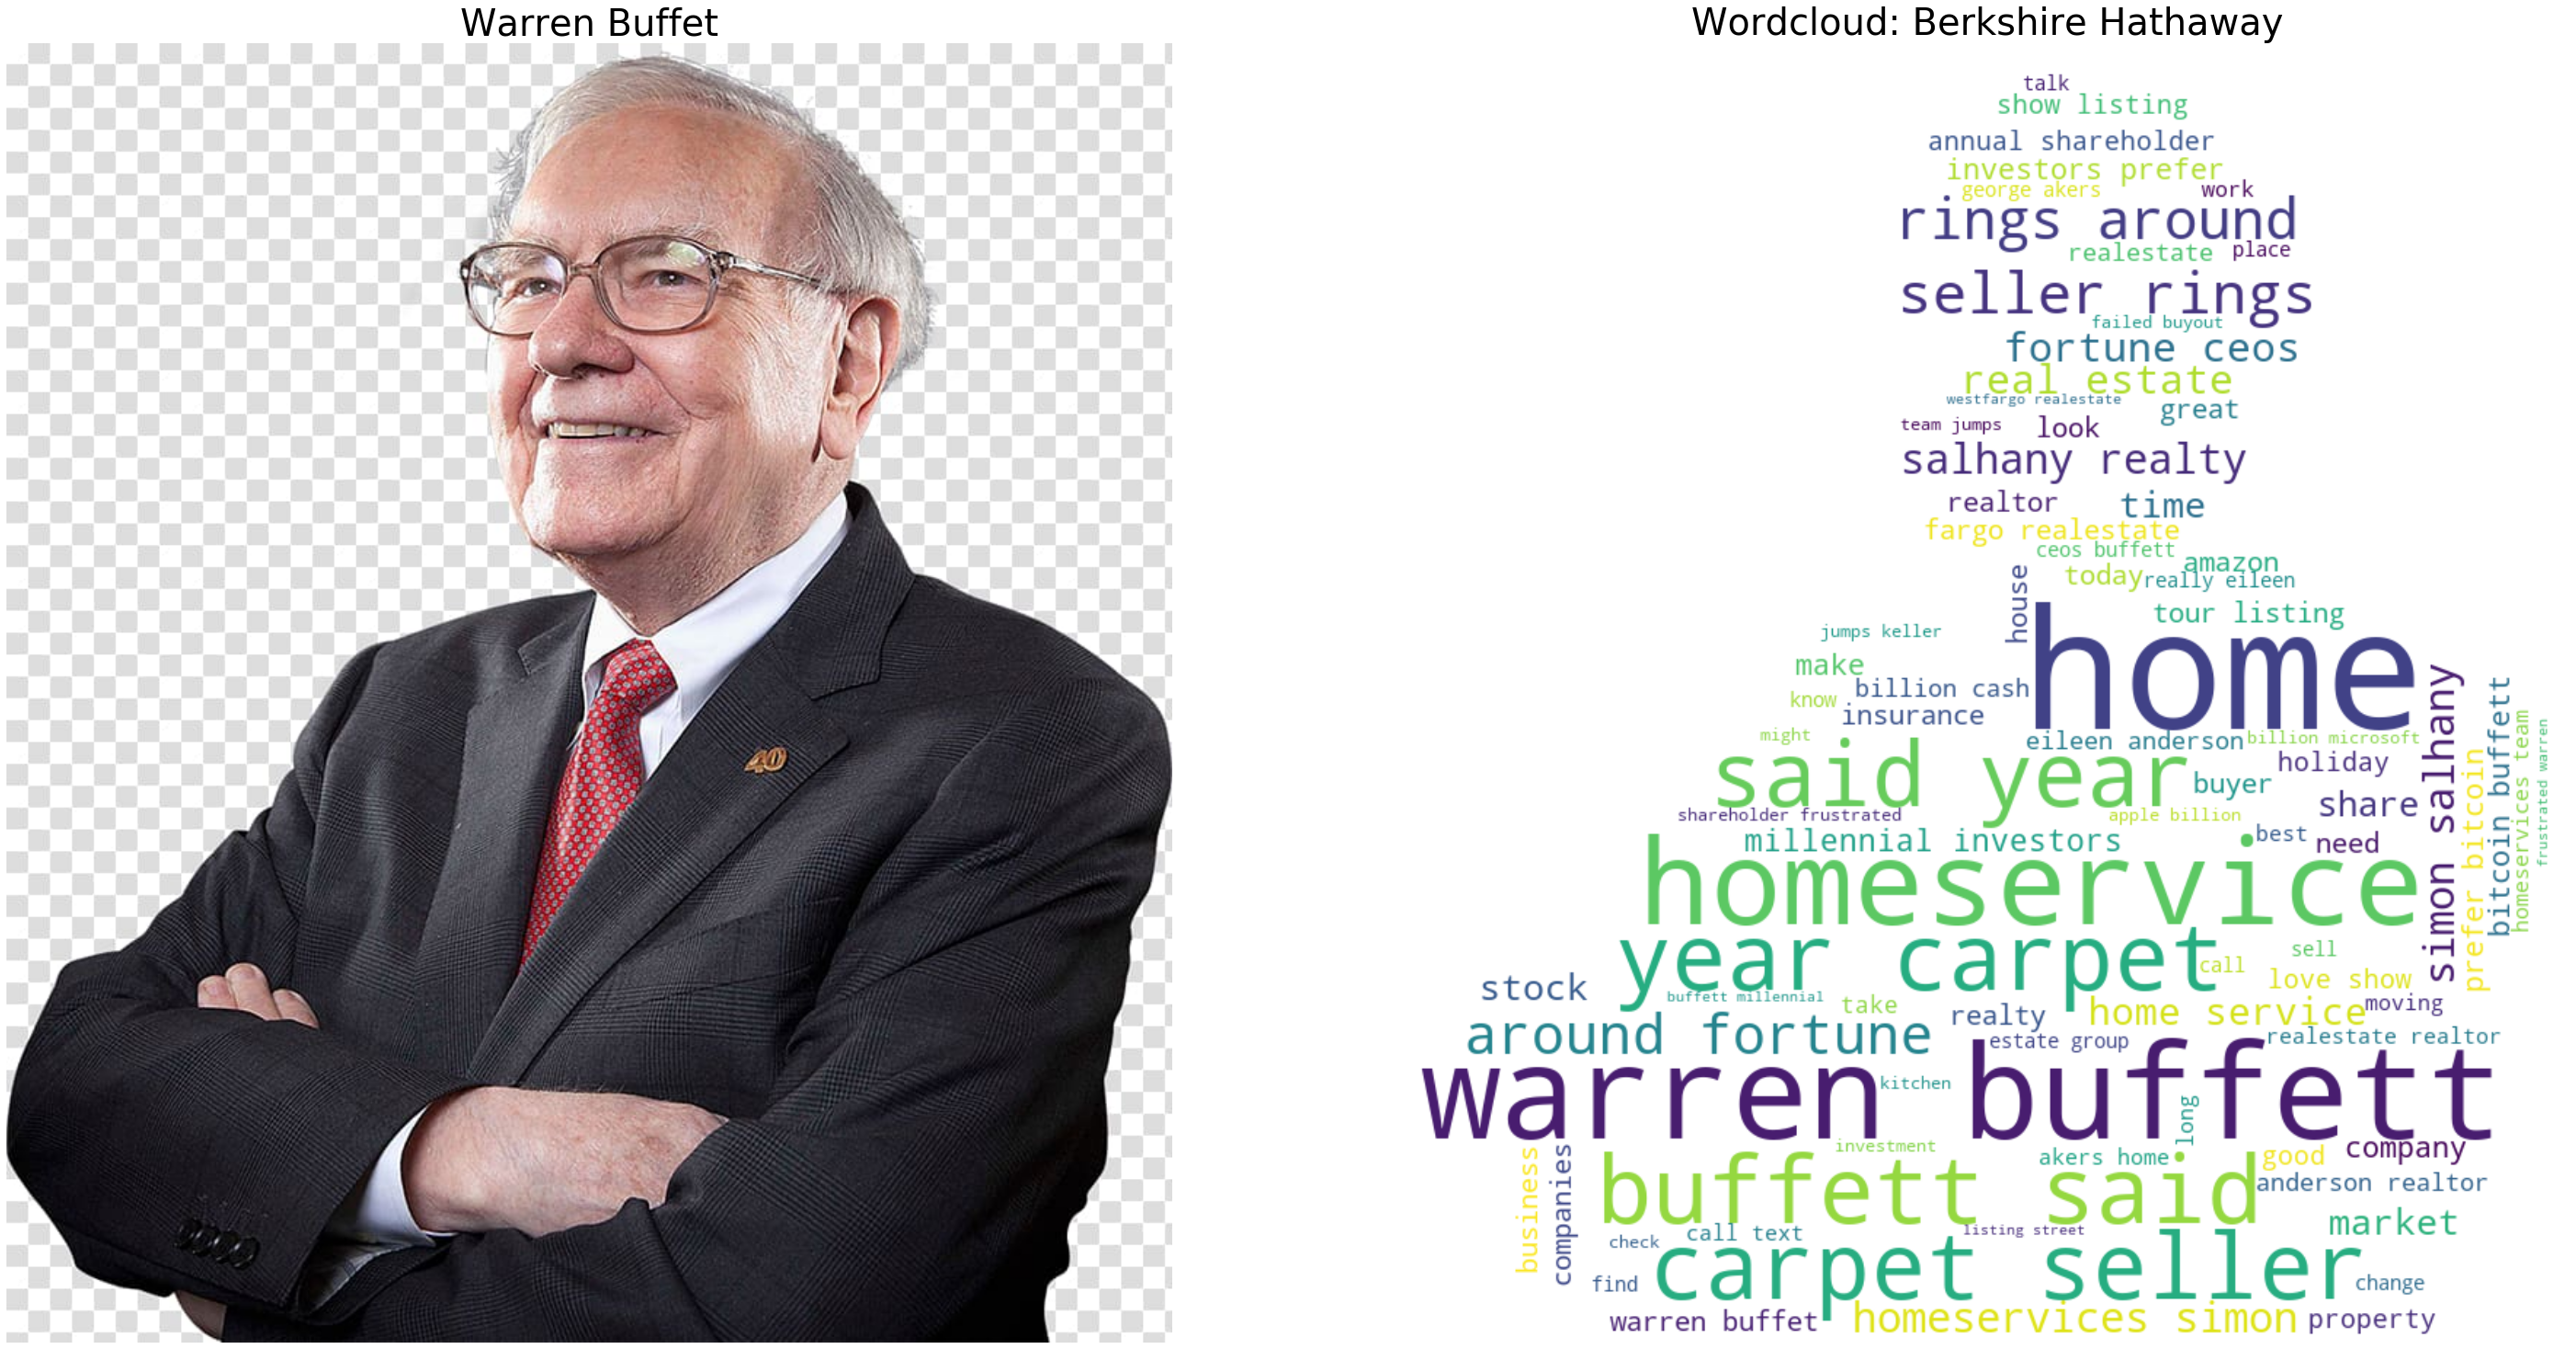

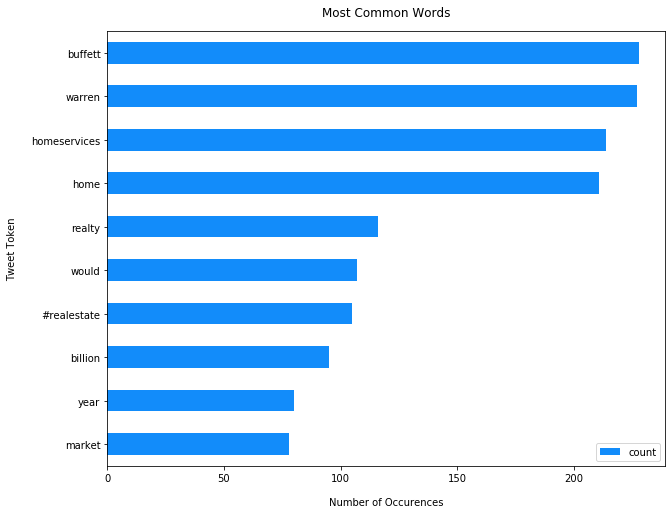

In [105]:
# Wordcloud & Topwords for Berkshire
drawordcloud(berkshire)
topwords(berkshire, 2, 12) # excludes bershire & hathaway

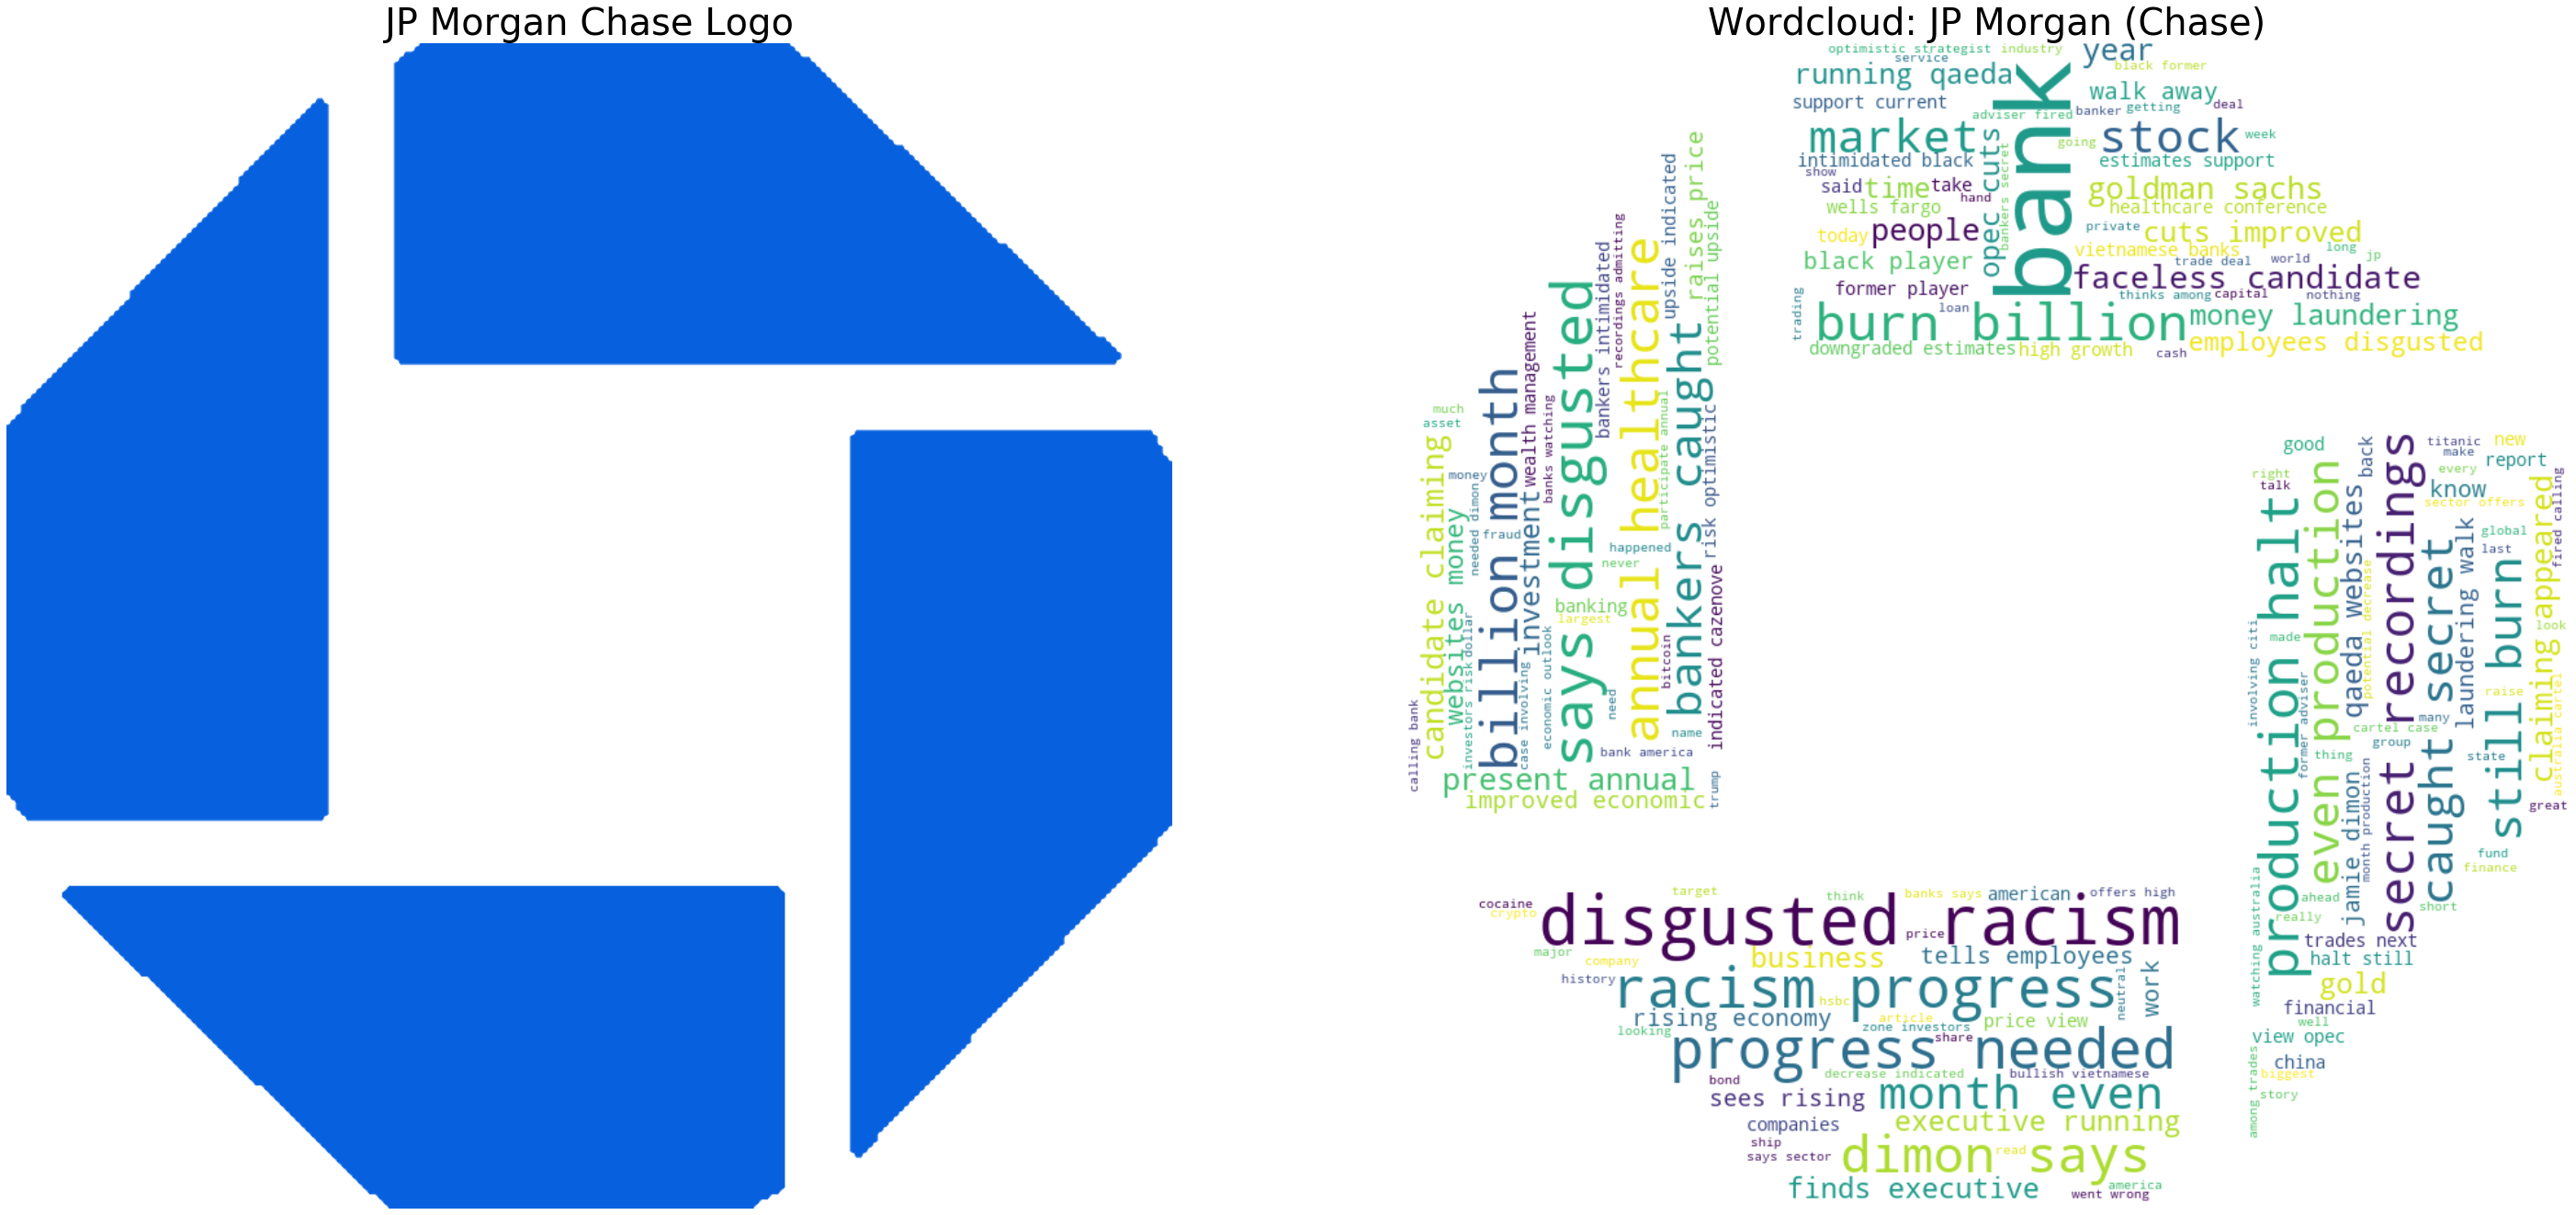

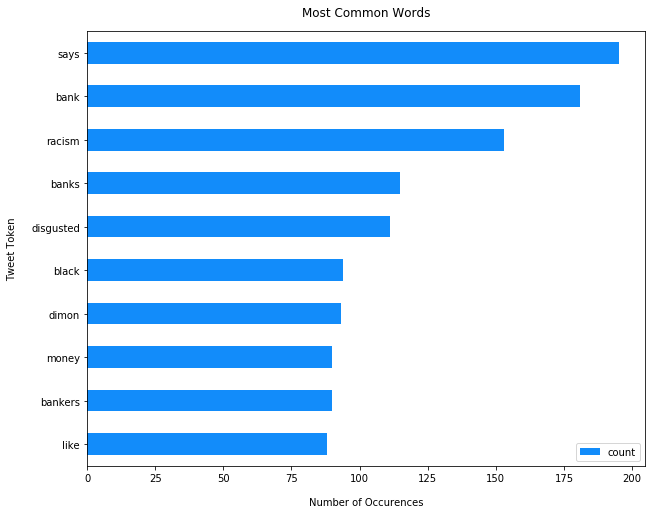

In [108]:
# Wordcloud & Topwords for JP Morgan
drawordcloud(jpmorgan)
topwords(jpmorgan, 2, 12) #excludes morgan & chase

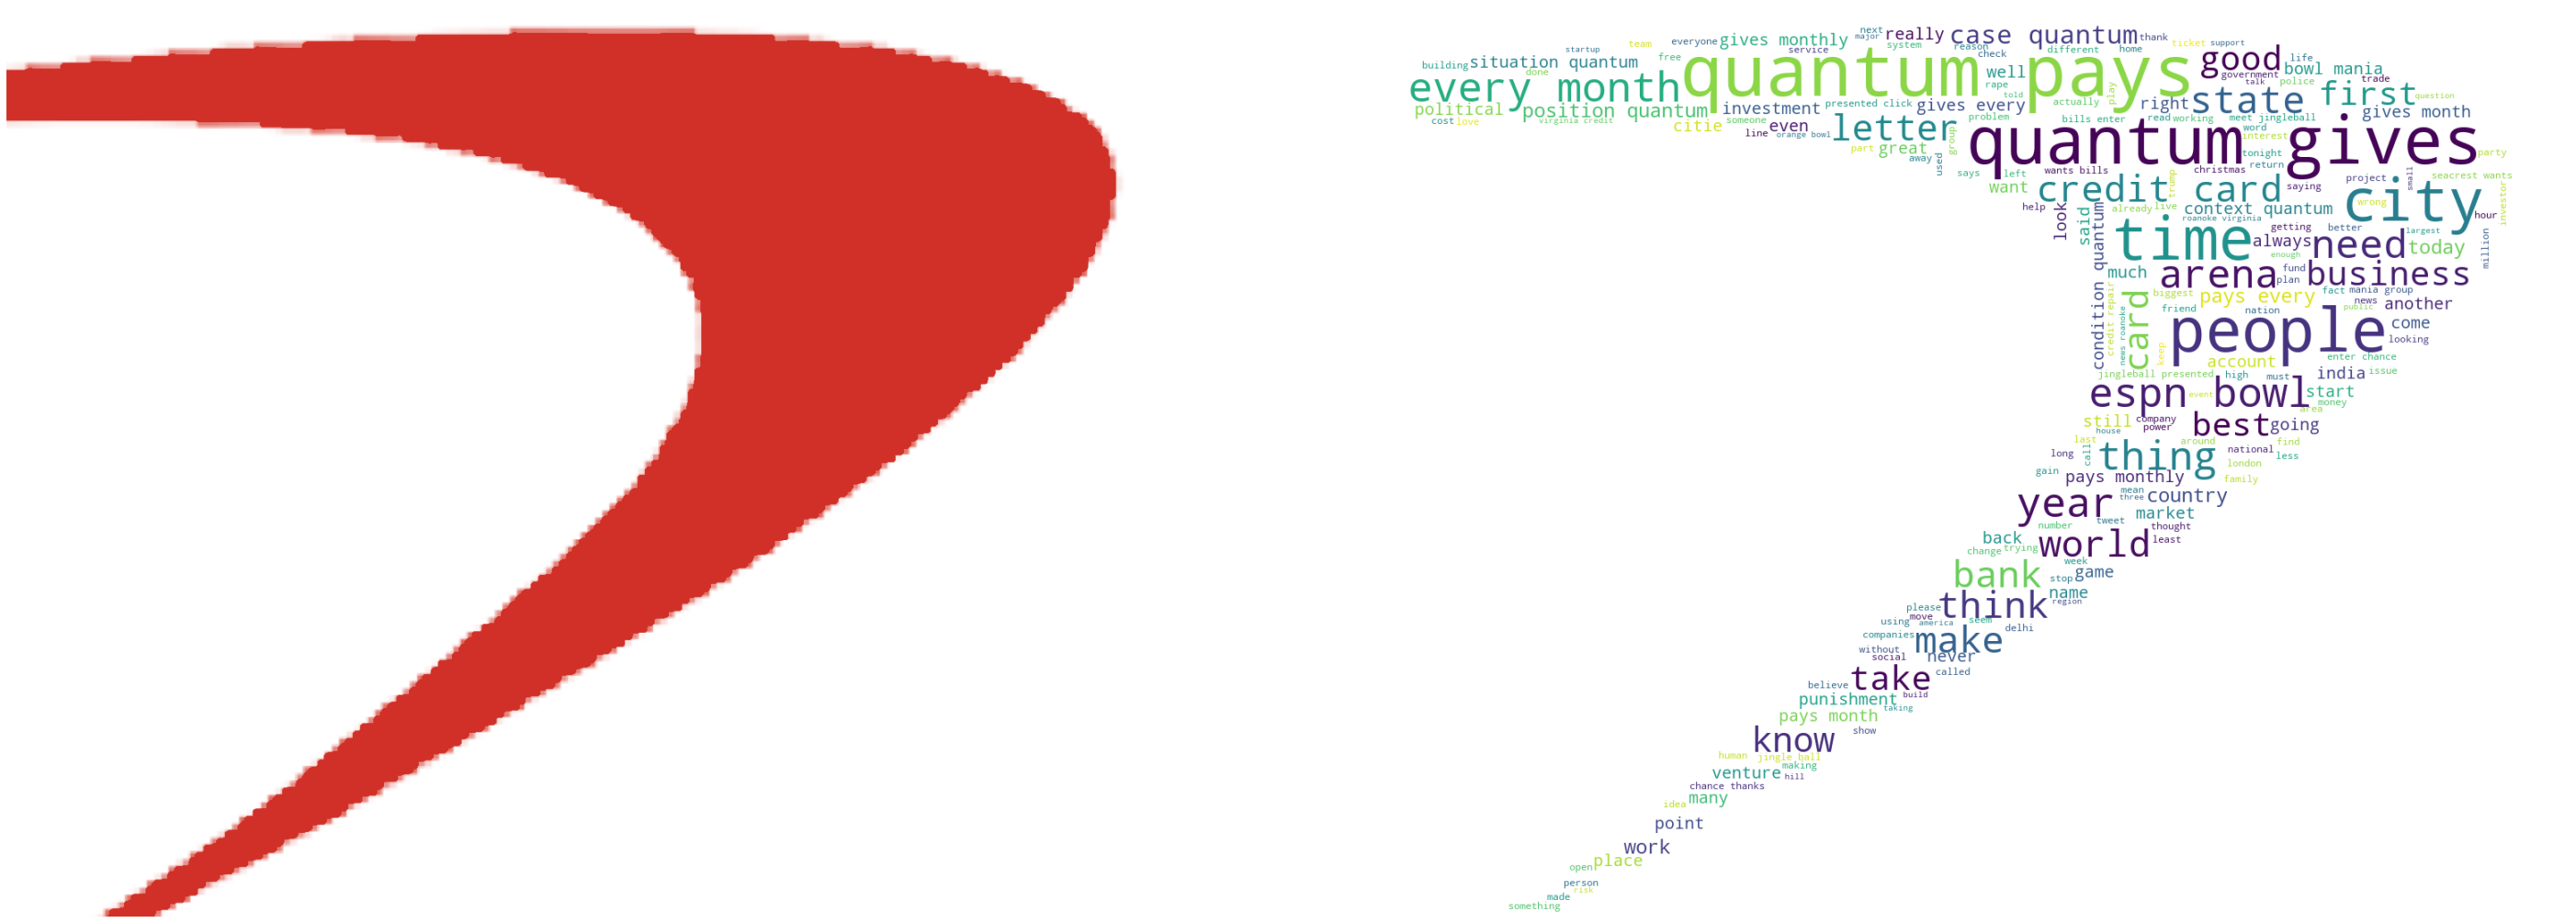

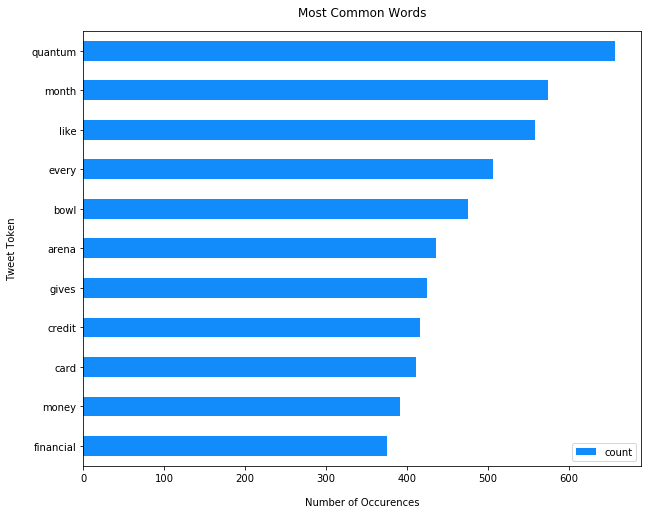

In [106]:
# Wordcloud & Topwords for Capital One
drawordcloud(capitalone)
topwords(capitalone, 1, 12) # excludes capital

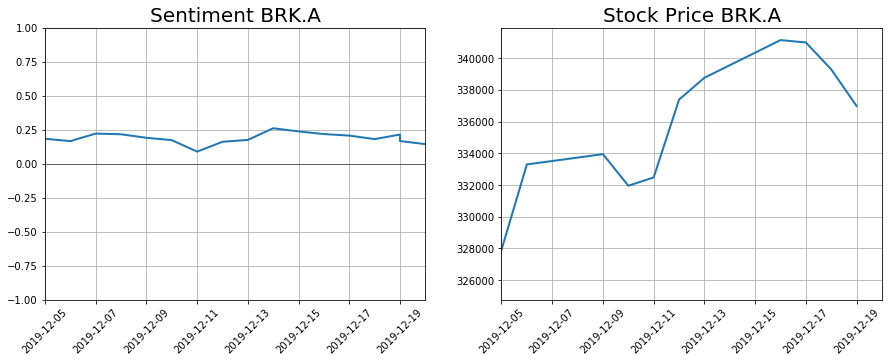

In [86]:
# Plot Sentiment and stock data for Berkshire Hathaway
plotgraphs(berkshire)

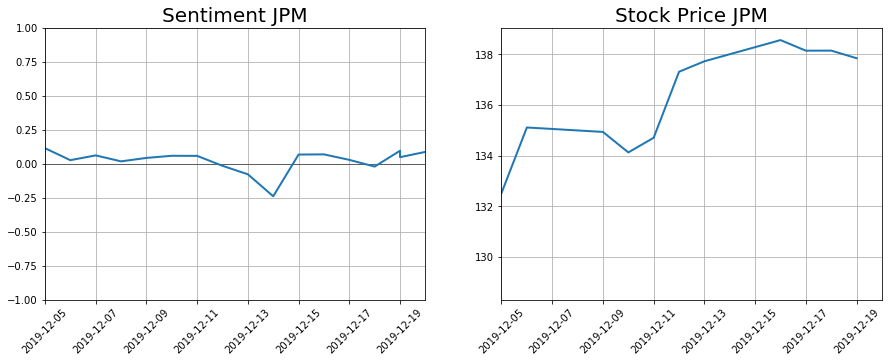

In [84]:
# Plot Sentiment and stock data for JP Morgan
plotgraphs(jpmorgan)

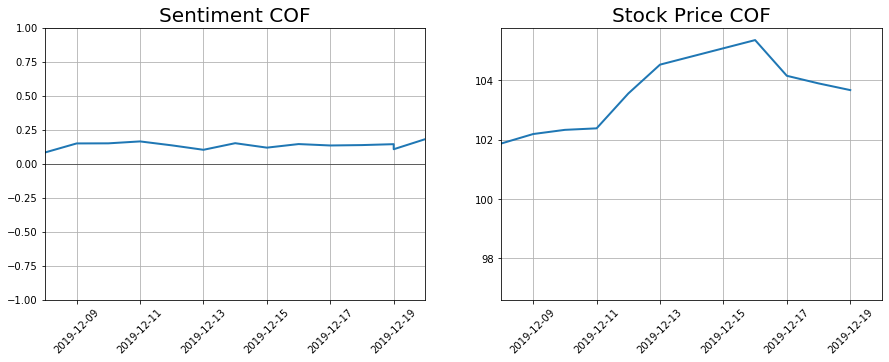

In [89]:
# Plot Sentiment and stock data for Capital One
plotgraphs(capitalone)

In [90]:
# Intertopic Distance Map for Berkshire Hathaway
topics(berkshire)

C:\Users\test\.conda\envs\r-environment\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [88]:
# Plot Sentiment and stock data for JP Morgan
topics(jpmorgan)

C:\Users\test\.conda\envs\r-environment\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [91]:
# Plot Sentiment and stock data for Capital One
topics(capitalone)

C:\Users\test\.conda\envs\r-environment\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
